In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import Fluka_dump_tools as fdt


In [2]:
N_files = 50
Energy = 3740
Rseed = 1

fluka_dir = '/Users/mghrear/Lab/HPS/fluka/'+str(Energy)+'MeV_userdump_s'+str(Rseed)+'/'

In [3]:
# Convert fluka dump files into pandas dataframes
fdt.FlukaDump_toPandas(fluka_dir, N_files, Energy)

#loop through saved pkl files and append them to a single DataFrame
df = pd.DataFrame()
for i in np.arange(1,N_files+1,1):
    i = str(i).zfill(3)
    file_name = fluka_dir+"phiKK_"+str(Energy)+ i + ".pkl"
    temp_df = pd.read_pickle(file_name)
    df = pd.concat([df, temp_df], ignore_index=True)
df.head()

,ProjID,ProjkE,ProjdirX,ProjdirY,ProjdirZ,Gen_No,IntID,NoSecondary,IDs,Ps,Xs,Ys,Zs
0,7,3.363326,-0.000027,-0.000457,1.0,2,101,4,"[8, 16, 15, 7]","[2.0863241346933203, 1.3959766266633853, 0.181...","[0.20282054899916518, -0.3893057108339896, 0.7...","[0.017216074199942085, -0.06061276473970396, 0...","[0.9790645697260315, 0.9191121565198946, -0.25..."
1,7,3.450865,-0.000203,0.000725,1.0,2,101,35,"[16, 15, 8, 1, 1, 8, 8, 1, 8, 8, 8, 8, 8, 1, 8...","[0.6508387294814963, 0.1807570242980634, 1.064...","[0.70690644679263, 0.5083894583643068, -0.4823...","[0.2443602653654536, -0.30839783505905133, 0.6...","[0.6637554792192254, 0.8040092872317688, 0.575..."
2,7,3.249103,0.000220,-0.000419,1.0,2,101,23,"[16, 15, 13, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[0.4692945871216088, 0.9553241173577816, 0.337...","[-0.6240857354628896, 0.5391874724649572, 0.71...","[0.7348041227748018, -0.4408279534772031, 0.69...","[0.26566877111338877, 0.7175984845092357, 0.03..."
3,7,3.440547,-0.000082,0.000113,1.0,2,101,12,"[16, 1, 15, 1, 8, 8, 8, 8, 8, 8, 8, 7]","[1.8321739850382024, 1.2791127581238353, 0.545...","[0.0032125559323020704, 0.06758609404678512, -...","[-0.19374192630578702, -0.37186128179242744, 0...","[0.9810472697458084, 0.9258246632031315, 0.384..."
4,7,3.733681,0.000085,0.000229,1.0,2,101,10,"[8, 13, 16, 15, 8, 8, 8, 8, 8, 8]","[0.6783147735316747, 0.5770923070076501, 1.150...","[-0.42645305886079027, -0.32587806456087137, 0...","[-0.5278888128642256, 0.15314610847421256, 0.2...","[0.7344870249644128, 0.9329253756315481, 0.936..."


In [4]:
# Keep only 2nd gen events, starting with a photon, with one K+ and one K- secondaries
df['Kflag'] = df.IDs.apply(lambda x: np.count_nonzero(x == 16) == 1)
df['Kflag2'] = df.IDs.apply(lambda x: np.count_nonzero(x == 15) == 1)
df_phiKK = df.loc[(df.Kflag == True)&(df.Kflag2 == True) &(df.Gen_No == 2)&(df.ProjID == 7)  ].reset_index(drop=True)


In [5]:
# mass of kaon
mK = 0.493677

# Get the momentum and energy of the kaons
df_phiKK['PKm'] = df_phiKK.apply(lambda row: np.array([row.Xs[row.IDs == 16].item(),row.Ys[row.IDs == 16].item(),row.Zs[row.IDs == 16].item()])*row.Ps[row.IDs == 16].item() , axis=1)
df_phiKK['PKp'] = df_phiKK.apply(lambda row: np.array([row.Xs[row.IDs == 15].item(),row.Ys[row.IDs == 15].item(),row.Zs[row.IDs == 15].item()])*row.Ps[row.IDs == 15].item() , axis=1)
df_phiKK['EKm'] = df_phiKK.apply(lambda row: mK/np.sqrt(1-( row.Ps[row.IDs == 16].item()**2 / ( mK**2 + row.Ps[row.IDs == 16].item()**2 ) )) , axis=1)
df_phiKK['EKp'] = df_phiKK.apply(lambda row: mK/np.sqrt(1-( row.Ps[row.IDs == 15].item()**2 / ( mK**2 + row.Ps[row.IDs == 15].item()**2 ) )) , axis=1)

# Calculate the invariant mass 
df_phiKK['M']= df_phiKK.apply(lambda row: np.sqrt((row.EKp+row.EKm)**2 - (row.PKm+row.PKp).dot(row.PKm+row.PKp)) , axis=1)



Text(0, 0.5, 'Counts')

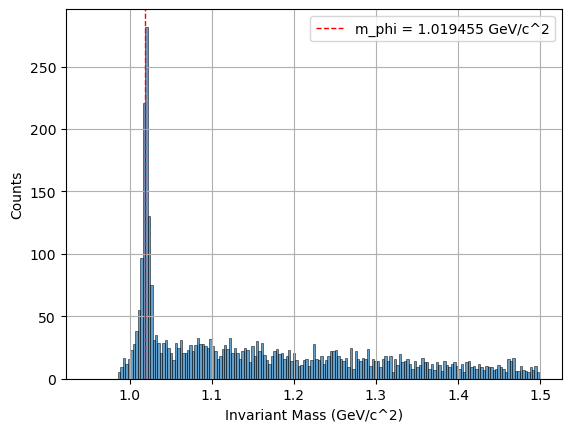

In [6]:
# mass of the phi meson
m_phi = 1.019455

df_phiKK.M.hist(bins=np.arange(0.95, 1.5, 0.003), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.axvline(m_phi, color='red', linestyle='dashed', linewidth=1, label='m_phi = 1.019455 GeV/c^2')
plt.legend()
plt.xlabel("Invariant Mass (GeV/c^2)")
plt.ylabel("Counts") 


Text(0, 0.5, 'Counts')

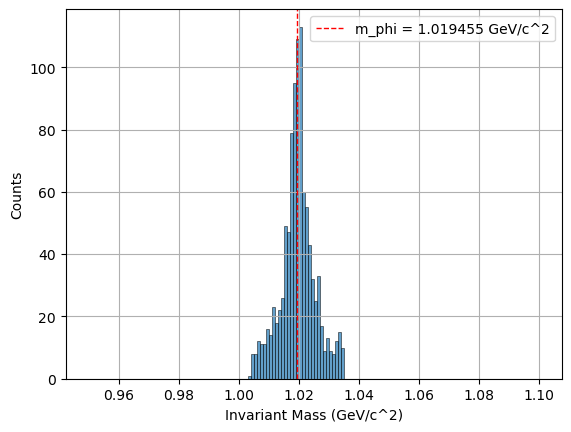

In [7]:
df_phiKK_cut = df_phiKK.loc[(df_phiKK.M > 1.00391) & (df_phiKK.M < 1.035)].reset_index(drop=True)

df_phiKK_cut.M.hist(bins=np.arange(0.95, 1.1, 0.001), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.axvline(m_phi, color='red', linestyle='dashed', linewidth=1, label='m_phi = 1.019455 GeV/c^2')
plt.legend()
plt.xlabel("Invariant Mass (GeV/c^2)")
plt.ylabel("Counts") 

In [8]:
df_phiKK_cut["PPhi"]=df_phiKK_cut.apply(lambda row: row.PKm+row.PKp, axis=1)
df_phiKK_cut["EPhi"]=df_phiKK_cut.apply(lambda row: row.EKm+row.EKp, axis=1)

Text(0, 0.5, 'counts')

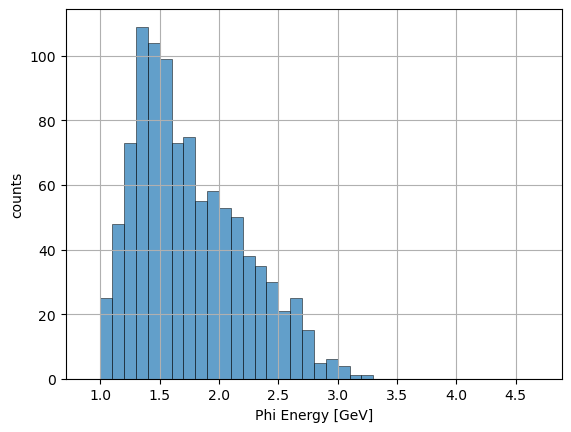

In [9]:
df_phiKK_cut.EPhi.hist(bins =  np.arange(0.9,4.8,0.1), edgecolor='black', linewidth=0.5, alpha=0.7)
plt.xlabel("Phi Energy [GeV]")
plt.ylabel("counts")

In [10]:
# Get all the fluka IDs for the secondary particles
unique_fluka_ids_df = df_phiKK_cut.explode('IDs')['IDs'].unique()


keys_view = fdt.flukaIDdict.keys()  # Get the view object
keys_list = np.array(list(keys_view))

missing_keys = np.setdiff1d(unique_fluka_ids_df, keys_list)

if len(missing_keys) > 0:
    print("Error add the following fluka IDs to flukaIDdict: ", missing_keys)

else:
    # Apply the conversion and create new columns
    df_phiKK_cut[['PDG_IDs', 'Sec_mass', 'Sec_charge']] = df_phiKK_cut['IDs'].apply(fdt.convert_fluka_ids).apply(pd.Series)

In [11]:
def write_lhe(df, fluka_dir, header_file="header.txt", include_recoil_e = False, include_other_secondaries = False):


    # Create lhe file and add header
    file = open(fluka_dir+'phi.lhe', "w")


    rscale = 1.740000e+02
    alpha_EM = 7.297353e-03  # Fine-structure constant
    alpha_QCD = 1.078706E-01
    beam_energy = 4.5

    #Write header 
    file.write(f"\n")

    file.write(f"<LesHouchesEvents version=\"3.0\">\n")
    file.write(f"<header>\n")
    file.write(f"#  Number of Events        :       "+str(len(df))+"\n")
    file.write(f"</header>\n")

    # Write the body of the LHE file
    file.write(f"<init>\n")
    file.write(f"{11} {623} {beam_energy:.6e} {rscale:.6e} {0} {0} {0} {0} {0} {1}\n")
    file.write("0 0 0 1\n")
    file.write(f"</init>\n")


    # Loop through the DataFrame and write the lines to the file
    for index, row in df.iterrows():

        # Start event block
        file.write(f"<event>\n")


        if include_other_secondaries and include_recoil_e:
            file.write(f"{1+row['NoSecondary']:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")
        elif include_other_secondaries and (include_recoil_e == False):
            file.write(f"{row['NoSecondary']:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")
        elif (include_other_secondaries == False) and (include_recoil_e):
            file.write(f"{3:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")
        else:
            file.write(f"{2:>2}{1:>7} {0} {rscale:.8e} {alpha_EM:.8e} {alpha_QCD:.8e} \n")

        # Include recoil electron if specified
        if include_recoil_e:
            file.write(f"{11:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{-row.ProjkE*row.ProjdirX:>+18.10e}{-row.ProjkE*row.ProjdirY:>+18.10e}{beam_energy-row.ProjkE*row.ProjdirZ:>+18.10e}{beam_energy-row.ProjkE:>17.10e}{5.11E-4:>17.10e}{0:>11.4e} {1:>.4e}\n")

        # Now include the secondaries
        for PDG_ID, P, x, y, z, m, c in zip(row.PDG_IDs,row.Ps,row.Xs,row.Ys,row.Zs, row.Sec_mass, row.Sec_charge):

            # Inlcude all secondaries if specified
            if include_other_secondaries:
                if m != 0:  #If it's not a Photon E= m/sqrt(1-P^2/(P^2 + m^2))
                    file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{m/np.sqrt(1-P**2/(m**2+P**2)):>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")
                else:       #If it is a Photon E = P 
                    file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{P:>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")
            
            # Otherwise only include the charged kaons
            elif (PDG_ID == 321) or (PDG_ID == -321):
                file.write(f"{PDG_ID:>9}{1:>3}{0:>5}{0:>5}{0:>5}{0:>5}{P*x:>+18.10e}{P*y:>+18.10e}{P*z:>+18.10e}{m/np.sqrt(1-P**2/(m**2+P**2)):>17.10e}{m:>17.10e}{0:>11.4e} {0:>.4e}\n")

        # end event block
        file.write(f"</event>\n")

    file.write(f"</LesHouchesEvents>")
    file.close()
    print(f"LHE file written to {fluka_dir}phi.lhe")


In [12]:
#df_phiKK_cut = df_phiKK_cut.loc[ df_phiKK_cut.NoSecondary ==2 ].reset_index(drop=True)  

In [13]:
write_lhe(df_phiKK_cut, fluka_dir, header_file="header.txt", include_recoil_e = True, include_other_secondaries = True)

LHE file written to /Users/mghrear/Lab/HPS/fluka/3740MeV_userdump_s1/phi.lhe
